In [6]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda:0")  # Use the first GPU (cuda:0)
else:
    print("GPU is not available")
    device = torch.device("cpu")  # Fallback to CPU

GPU is available


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import exp, log, sqrt
from scipy.special import erf

In [8]:
# Given in assignment
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

European Call Option Price: 0.5977
European Put Option Price: 0.6026


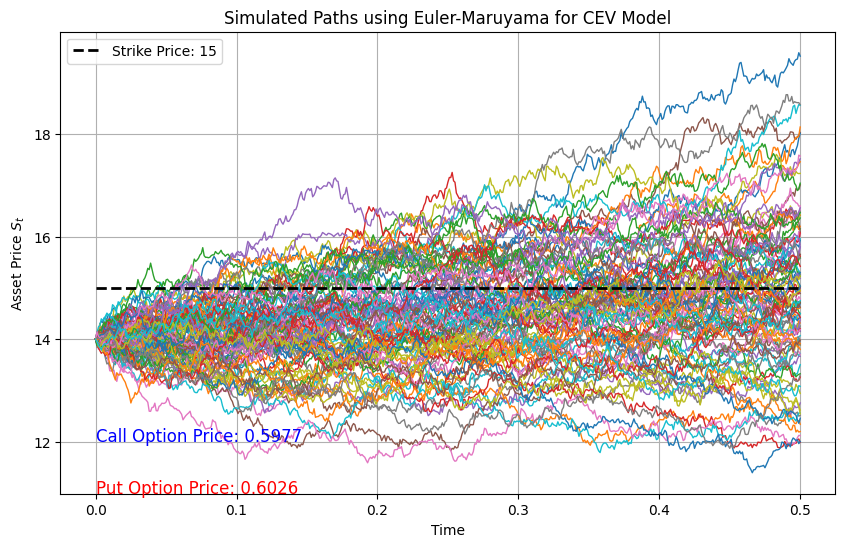

In [9]:
# Parameters for the CEV model
r = 0.1          # Risk-free rate
sigma = 0.25     # Volatility
gamma = 0.8      # Elasticity parameter
S0 = 14          # Initial value of the asset
T = 0.5          # Time horizon
N = 500          # Number of time steps
dt = T / N       # Time step size
n_simulations = 100  # Number of simulation paths
K = 15           # Strike price of the option

# Generate random Brownian increments
dW = np.random.normal(0, np.sqrt(dt), (n_simulations, N))

# Initialize array to store the simulated paths
S = np.zeros((n_simulations, N + 1))
S[:, 0] = S0

# Euler-Maruyama method to simulate the paths
for i in range(N):
    S[:, i+1] = S[:, i] + r * S[:, i] * dt + sigma * S[:, i]**gamma * dW[:, i]

# Compute the payoff at maturity for each simulation path
payoffs_call = np.maximum(S[:, -1] - K, 0)
payoffs_put = np.maximum(K-S[:, -1], 0)

# Calculate the mean of the payoffs
mean_payoff_call = np.mean(payoffs_call)
mean_payoff_put = np.mean(payoffs_put)

# Calculate the standard deviation of the payoffs
std_payoff_call = np.std(payoffs_call)
std_payoff_put = np.std(payoffs_put)

# Discount the mean payoff to present value
call_option_price = np.exp(-r * T) * mean_payoff_call
put_option_price = np.exp(-r * T) * mean_payoff_put

# Output the call and put option prices
print(f"European Call Option Price: {call_option_price:.4f}")
print(f"European Put Option Price: {put_option_price:.4f}")

# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for j in range(n_simulations):
    plt.plot(np.linspace(0, T, N+1), S[j, :], lw=1)
plt.plot([0, T], [K, K], 'k--', lw=2, label=f'Strike Price: {K}')
plt.text(0.0, 12, f'Call Option Price: {call_option_price:.4f}', fontsize=12, color='blue')
plt.text(0.0, 11, f'Put Option Price: {put_option_price:.4f}', fontsize=12, color='red')
plt.legend()
plt.title('Simulated Paths using Euler-Maruyama for CEV Model')
plt.xlabel('Time')
plt.ylabel('Asset Price $S_t$')
plt.grid(True)
plt.show()

Using device: cuda


100%|██████████| 15/15 [00:00<00:00, 5563.23it/s]

Time step sizes:  [1, 5, 10, 15]
Discretization Errors:  [0.06298082785077508, 0.009430167240576104, 0.004492876095251397, 0.00368386225171502]


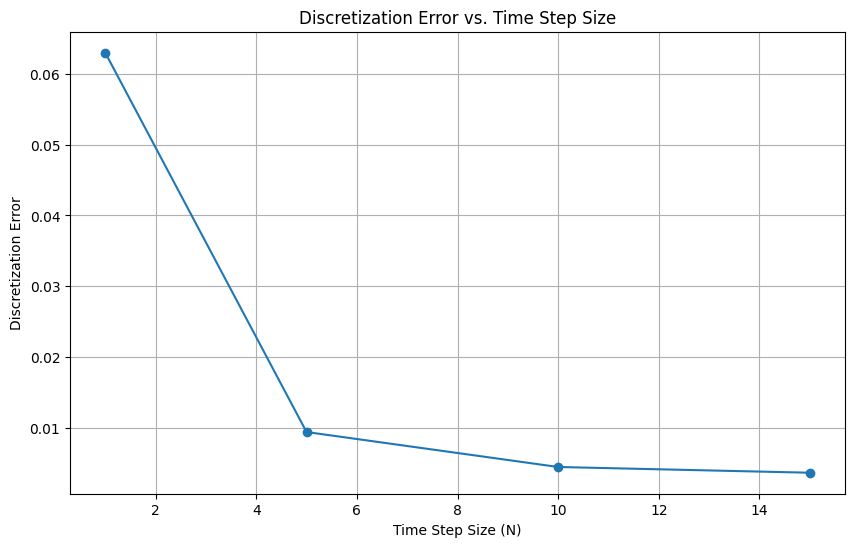

In [31]:
### DISCRETIZATION ERROR TORCH EFFECTIVE ###

# Function to simulate the option price with given time steps (N)
def simulate_option_price(N, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is the Black-Scholes case)
    S0 = 14          # Initial value of the asset
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate random walk
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Initialize the asset price
    S = torch.full((n_simulations,), S0, dtype=torch.float32, device=device)

    for i in tqdm(range(N)):
        # Update the asset prices in place
        S += r * S * dt + sigma * S**gamma * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes
    F = bsexact(sigma, r, K, T, S0)

    # Compute the discretization error
    discretization_error = abs(call_option_price.item() - F)
    return discretization_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different time steps
N_values = [1, 5, 10, 15]
discretization_errors = [simulate_option_price(N, device) for N in N_values]

# Print the results
print("Time step sizes: ", N_values)
print("Discretization Errors: ", discretization_errors)

# Plot the option price as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors, 'o-')
plt.title('Discretization Error vs. Time Step Size')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.show()

Using device: cuda


100%|██████████| 100000/100000 [00:10<00:00, 9936.75it/s]


Number of simulations: [10, 100, 1000, 10000]
Sample Error: [0.25292420669130866, 0.09550511555142815, 0.006642696423010186, 0.01615959124036248]


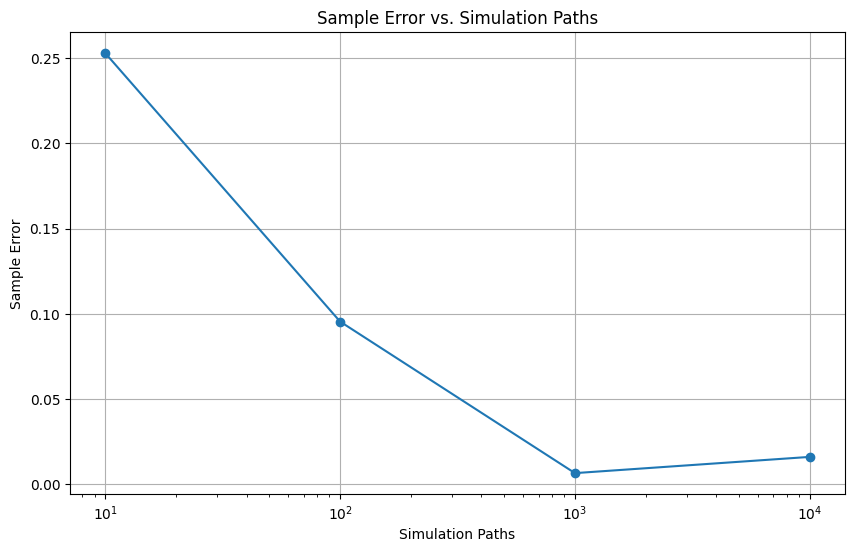

In [26]:
### SAMPLE ERROR TORCH EFFECTIVE ###

# Function to simulate the sample error with a given number of simulations
def simulate_option_price(n_simulations, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset
    T = 0.5          # Time horizon
    N = int(1e5)     # Number of time steps
    dt = T / N       # Time step size
    K = 15           # Strike price of the option

    # Generate random walk
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate asset price paths
    S = torch.zeros((n_simulations,), dtype=torch.float32, device=device)
    S[:] = S0

    for i in tqdm(range(N)):
        S += r * S * dt + sigma * S**gamma * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Calculate option price using discounted payoff
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes
    F = bsexact(sigma, r, K, T, S0)

    # Compute the sample error
    sample_error = abs(call_option_price.item() - F)

    return sample_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different number of simulation paths
n_values = [int(1e1), int(1e2), int(1e3), int(1e4)]
sample_errors = [simulate_option_price(n, device) for n in n_values]

# Print the results
print("Number of simulations:", n_values)
print("Sample Error:", sample_errors)

# Plot the sample error as a function of the number of simulations
plt.figure(figsize=(10, 6))
plt.semilogx(n_values, sample_errors, 'o-')
plt.title('Sample Error vs. Simulation Paths')
plt.xlabel('Simulation Paths')
plt.ylabel('Sample Error')
plt.grid(True)
plt.show()

Using device: cuda


100%|██████████| 100000/100000 [00:21<00:00, 4760.16it/s]


Simulation Paths: [10, 100, 1000, 10000]
Sample Errors with Antithetic Variates: [0.2794748516506713, 0.01653015895418708, 0.024882498221917793, 0.0018543629222351754]


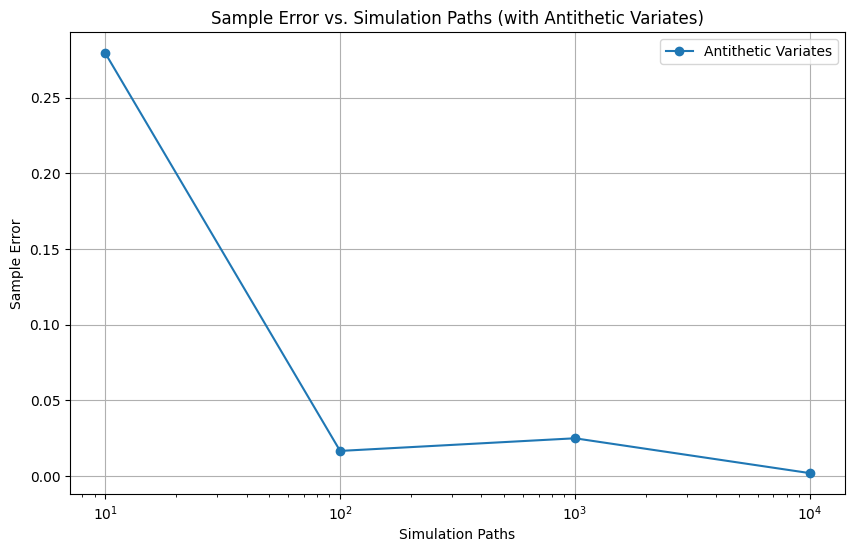

In [12]:
### SAMPLE ERROR - ANTIHETIC VARIATES TORCH EFFECTIVE ###

# Function to simulate the sample error using antithetic variates
def simulate_option_price_antithetic(n_simulations, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset
    T = 0.5          # Time horizon
    N = int(1e5)     # Number of time steps
    dt = T / N       # Time step size
    K = 15           # Strike price of the option

    # Generate Brownian motion increments for original and antithetic paths
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)
    dW_antithetic = -dW  # Antithetic variates by negating dW

    # Simulate asset price paths for original and antithetic variables
    S = torch.full((n_simulations,), S0, dtype=torch.float32, device=device)
    S_antithetic = torch.full((n_simulations,), S0, dtype=torch.float32, device=device)

    for i in tqdm(range(N)):
        # Original path
        S += r * S * dt + sigma * S**gamma * dW[:, i]
        # Antithetic path
        S_antithetic += r * S_antithetic * dt + sigma * S_antithetic**gamma * dW_antithetic[:, i]

    # Compute payoffs for both original and antithetic paths
    payoffs = torch.maximum(S - K, torch.tensor(0.0, device=device))
    payoffs_antithetic = torch.maximum(S_antithetic - K, torch.tensor(0.0, device=device))

    # Average the payoffs from original and antithetic paths
    mean_payoff = torch.mean((payoffs + payoffs_antithetic) / 2)

    # Discounted payoff
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes formula
    F = bsexact(sigma, r, K, T, S0)

    # Calculate sample error
    sample_error = abs(call_option_price.item() - F)

    return sample_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different numbers of paths using antithetic variates
n_values = [int(1e1), int(1e2), int(1e3), int(1e4)]
sample_errors_antithetic = [simulate_option_price_antithetic(n, device) for n in n_values]

# Print the results
print("Simulation Paths:", n_values)
print("Sample Errors with Antithetic Variates:", sample_errors_antithetic)

# Plot the sample error as a function of the number of simulations using antithetic variates
plt.figure(figsize=(10, 6))
plt.semilogx(n_values, sample_errors_antithetic, 'o-', label="Antithetic Variates")
plt.title('Sample Error vs. Simulation Paths (with Antithetic Variates)')
plt.xlabel('Simulation Paths')
plt.ylabel('Sample Error')
plt.grid(True)
plt.legend()
plt.show()

Using device: cuda


100%|██████████| 25/25 [00:00<00:00, 2886.09it/s]

Time Steps: [1, 5, 10, 25]
Discretization Errors (Milstein): [0.06020354942746575, 0.010049936336950616, 0.007480856937841729, 0.0035943956799071586]


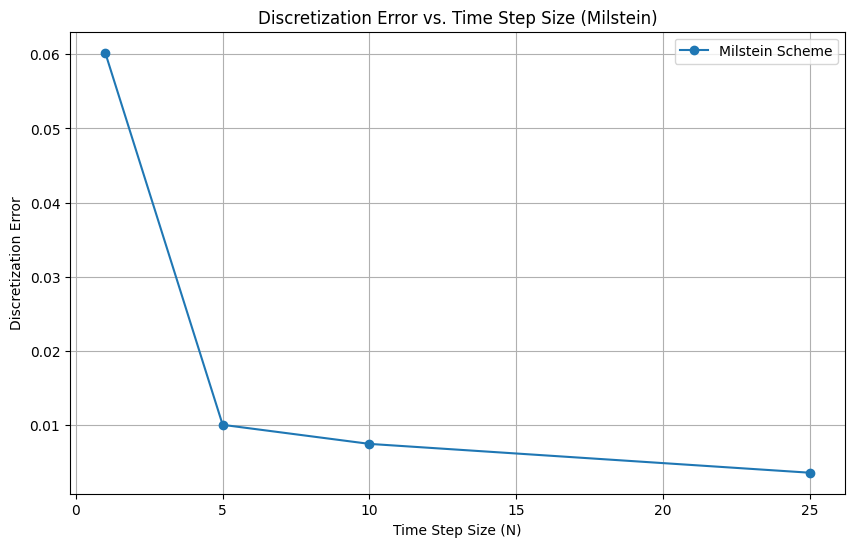

In [32]:
### DISCRETIZATION ERROR WITH MILSTEIN SCHEME TORCH EFFECTIVE ###

# Function to simulate the option price using the Milstein scheme with given time steps (N)
def simulate_option_price_milstein(N, device):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    gamma = 1        # Elasticity parameter (gamma=1 is Black-Scholes)
    S0 = 14          # Initial value of the asset
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate standard Brownian increments
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate paths using the Milstein scheme
    S = torch.zeros((n_simulations,), dtype=torch.float32, device=device)
    S[:] = S0

    for i in tqdm(range(N)):
        S_current = S

        # Drift and diffusion terms
        drift = r * S_current
        diffusion = sigma * S_current**gamma

        # Milstein step
        S += drift * dt + diffusion * dW[:, i] + 0.5 * sigma * gamma * S_current**(gamma-1) * (dW[:, i]**2 - dt)

    # Compute the payoff at maturity
    payoffs = torch.maximum(S - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Discounted payoff
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    # Exact price using Black-Scholes formula
    F = bsexact(sigma, r, K, T, S0)

    # Compute discretization error
    discretization_error = abs(call_option_price.item() - F)
    return discretization_error

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Run simulations with different time steps using the Milstein scheme
N_values = [1, 5, 10, 25]
discretization_errors_milstein = [simulate_option_price_milstein(N, device) for N in N_values]

# Print the results
print("Time Steps:", N_values)
print("Discretization Errors (Milstein):", discretization_errors_milstein)

# Plot the discretization error as a function of the time step size
plt.figure(figsize=(10, 6))
plt.plot(N_values, discretization_errors_milstein, 'o-', label='Milstein Scheme')
plt.title('Discretization Error vs. Time Step Size (Milstein)')
plt.xlabel('Time Step Size (N)')
plt.ylabel('Discretization Error')
plt.grid(True)
plt.legend()
plt.show()

Using device: cuda


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Gamma Values: [0.5        0.55555556 0.61111111 0.66666667 0.72222222 0.77777778
 0.83333333 0.88888889 0.94444444 1.        ]
Option Prices: [0.14871595799922943, 0.18852300941944122, 0.23457776010036469, 0.2881222367286682, 0.35220128297805786, 0.4256047308444977, 0.5116950869560242, 0.6140864491462708, 0.7294932007789612, 0.8671974539756775]


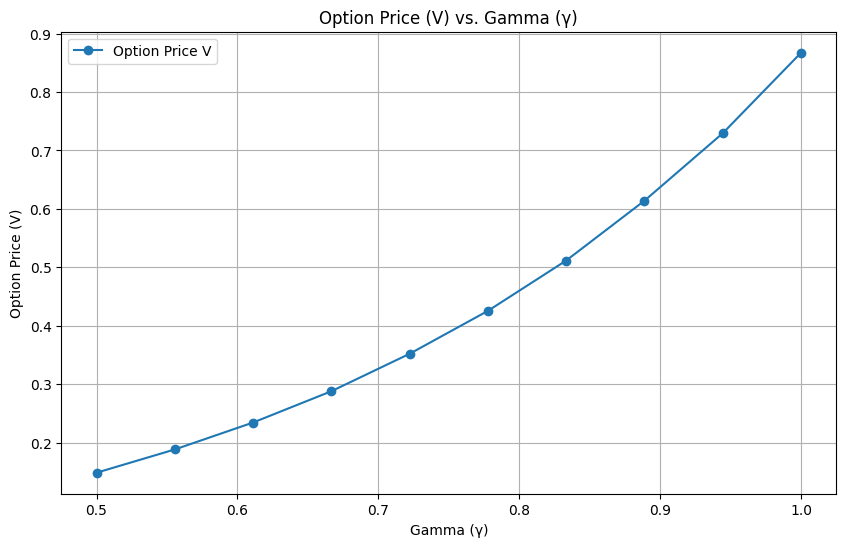

In [14]:
### GAMMA TORCH EFFECTIVE ###

# Function to compute the option price as a function of gamma using PyTorch and Euler-Maruyama method
def compute_option_price_for_gamma(gamma, N=500, device='cpu'):
    # Parameters for the CEV model
    r = 0.1          # Risk-free rate
    sigma = 0.25     # Volatility
    S0 = 14          # Initial value of the asset
    T = 0.5          # Time horizon
    dt = T / N       # Time step size
    n_simulations = int(1e6)  # Number of simulation paths
    K = 15           # Strike price of the option

    # Generate standard Brownian increments
    dW = torch.randn((n_simulations, N), device=device) * np.sqrt(dt)

    # Simulate paths using Euler-Maruyama on GPU
    S = torch.full((n_simulations,), S0, dtype=torch.float32, device=device)

    for i in range(N):
        # Euler-Maruyama step
        drift = r * S
        diffusion = sigma * S**gamma
        S += drift * dt + diffusion * dW[:, i]

    # Compute the payoff at maturity
    payoffs = torch.maximum(S - K, torch.tensor(0.0, device=device))
    mean_payoff = torch.mean(payoffs)

    # Discounted payoff (call option price)
    call_option_price = torch.exp(torch.tensor(-r * T, device=device)) * mean_payoff

    return call_option_price.item()

# Set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Range of gamma values to test
gamma_values = np.linspace(0.5, 1.0, 10)  # You can adjust the range of gamma values

# Compute the option prices for different gamma values
option_prices = [compute_option_price_for_gamma(gamma, device=device) for gamma in tqdm(gamma_values)]

# Print the results
print("Gamma Values:", gamma_values)
print("Option Prices:", option_prices)

# Plot the option price as a function of gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, option_prices, 'o-', label='Option Price V')
plt.title('Option Price (V) vs. Gamma (γ)')
plt.xlabel('Gamma (γ)')
plt.ylabel('Option Price (V)')
plt.grid(True)
plt.legend()
plt.show()